In [53]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14535310914004627458
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7807696896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4081328056383378737
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# 전처리

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [55]:
BASE_DIR = "."

In [56]:
def crop(img_num):
    file = f"{BASE_DIR}/dataset/Item-Image/img{img_num}.jpg"
    img1 = cv2.imread(file)
    
    # Image Shape
    h, w = img1.shape[:2]
    h1, h2 = int(h * 0.2), int(h * 0.7)
    w1, w2 = int(w * 0.05), int(w * 0.95)
    img = img1[h1: h2, w1: w2]
    
    # Resolution
    img = cv2.resize(img, None, fx=0.75, fy=0.75, interpolation=cv2.INTER_AREA)
    
    # Gray Scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Adaptive Threshold
    img2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    
    #Blur
    blur = cv2.medianBlur(img2, 5, dst=None)
    
    # Add Kernel
    kernel = np.ones((3,3),np.uint8)
    
    # Morphology
    closing = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel)
    gradient = cv2.morphologyEx(closing, cv2.MORPH_GRADIENT, kernel)
    
    # 경계값 도출
    contours = cv2.findContours(gradient, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)[0]

    x1 = [] #x-min
    y1 = [] #y-min
    x2 = [] #x-max
    y2 = [] #y-max
    for i in range(1, len(contours)):
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)
    cv2.rectangle(gradient, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 3)

    origial_img = gray[y1_min:y2_max, x1_min:x2_max]
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    
    crop_img = cv2.resize(crop_img, (32, 32))
    
    #img_merge = np.hstack((origial_img, crop_img))
    
    #return img_merge
    
    return crop_img

In [57]:
def labeling(img_num):
    with open(f"{BASE_DIR}/dataset/Item-Parse_f/img{img_num}.json", "r", encoding="utf8") as f:
        contents = f.read()
        json_data = json.loads(contents)
        #label = json_data["category_name"]
        label = json_data["category_id"]
        
        return label

In [58]:
def test(count):
    for img_num in range(count):
        crop_img = crop(img_num)
        #print(crop_img)
        label = labeling(img_num)

        plt.imshow(crop_img, cmap='gray')
        plt.title(f'img{img_num} {label}')
        plt.show()

In [59]:
def save(img_num): # 이미지 번호를 인자로 받고 크롭, 라벨링 후 파일 저장
    img = crop(img_num)
    label = labeling(img_num)
    save_src = f"./labeling/{label}/img{img_num}.jpg"
    
    cv2.imwrite(save_src, img)

In [60]:
def save_run(count): #이미지 수를 인자로 받음
  for img_num in range(count):
    save(img_num)
    print(f"img{img_num} saved")

# 학습코드

In [61]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dense, Conv2D
from tqdm import tqdm
from tqdm import trange

from numba import jit, cuda, prange

In [62]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5 * 1024)])
#   except RuntimeError as e:
#     print(e)

In [63]:
labelTable = ["cap_and_hat", "outerwear", "tops", "bottoms", "shoes"]

In [64]:
xDatas = []
yDatas = []

In [65]:
#@jit(forceobj = True, target_backend="cuda")
def insertDatas():
    for imgNum in trange(30000):
        img = crop(imgNum)
        label = labeling(imgNum)
        xDatas.append(img)
        yDatas.append(label)

In [66]:
insertDatas()

xDatas = np.array(xDatas)
yDatas = np.array(yDatas)

np.save(f'{BASE_DIR}/xDatas32', xDatas)
np.save(f'{BASE_DIR}/yDatas', yDatas)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:35<00:00, 89.35it/s]


In [68]:
xDatas = np.load(f'{BASE_DIR}/xDatas32.npy')
yDatas = np.load(f'{BASE_DIR}/yDatas.npy')

print(len(xDatas))
print(len(yDatas))

30000
30000


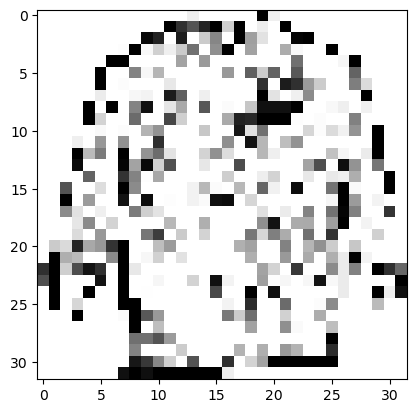

In [26]:
img = crop(11)
label = labeling(1)
plt.imshow(img, cmap='gray')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xTrain, xValidation, yTrain, yValidation = train_test_split(xDatas, yDatas, test_size=0.2, stratify=yDatas, random_state=1120)

In [ ]:
imRows = 128
imCols = 128

inputShape = (imRows, imCols, 1)

In [ ]:
with tf.device("CPU:0"):
    xTrain = tf.convert_to_tensor(xTrain, dtype=tf.float32)
    xValidation = tf.convert_to_tensor(xValidation, dtype=tf.float32)
    yTrain = tf.one_hot(yTrain, depth=len(np.unique(yTrain)))
    yValidation = tf.one_hot(yValidation, depth=len(np.unique(yValidation)))

In [ ]:
print(yTrain[0])

In [ ]:
num_classes = 5   #10개 클래스 기억
model = Sequential()   #순차적으로 레이어를 더해주는 명령

#첫번째 컨볼루션 레이어
#입력 레이어
#컨볼루션 레이어의 컨볼루션 연산과 폴링 연산 설정
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding="valid",
                 input_shape=inputShape))   #서로 다른 64개의 필터를 3x3사이즈로 설정하여 연산함. 이때, 최적화함수는 relu(음수는 0으로 반환), 패딩은 사이즈를 작게 두는 valid 옵션 사용
model.add(MaxPooling2D(2))   #폴링필터를 2x2로 설정하여 연산함. MaxPooling2D(2,2)와 같음
model.add(Dropout(0.3))   #30%의 노드를 삭제함

#두번째 컨볼루션 레이어
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='valid'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))

#세번째 컨볼루션 레이어 
model.add(Conv2D(128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.3))

#첫번째 완전 연결(Fully Connected) 레이어
model.add(Flatten())   #다차원을 1차원으로 변경해주는 명령

#두번째 완전 연결(Fully Connected) 레이어, 
model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))   #노드의 갯수가 256개인 히든레이어

#세번째 완전 연결(Fully Connected) 레이어, 
model.add(Dense(256, kernel_initializer='he_normal', activation='relu'))

#네번째 완전 연결(Fully Connected) 레이어
#출력 레이어
model.add(Dense(num_classes, activation='softmax'))   #출력 레이어의 노드의 갯수는 분류할 10개 클래스와 같아야 함, softmax() 함수는 학습데이터에 얼마나 가까워졌는지 정도를 보여주는 방법임

In [ ]:
model.summary()

In [ ]:
#모델 학습방식 환경설정(최적화함수, 손실함수, 평가지표)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",     
              metrics=["accuracy"])

In [ ]:
#모델 학습실행하는 명령
with tf.device("GPU:0"):
    tracker = model.fit(xTrain, yTrain,
                    batch_size=20,
                    epochs=50,
                    validation_data=(xValidation, yValidation),
                    verbose=1)